In [1]:
import acgan
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
#tf.enable_eager_execution()

BATCH_SIZE = 32
session = tf.InteractiveSession()

In [2]:
#tfds.list_builders()

In [3]:
dataset, info = tfds.load('mnist', with_info=True,
                          split=tfds.Split.TRAIN)
dataset = dataset.repeat()\
                 .map(lambda x: (tf.cast(x['image'], tf.float32)-127.5)/127.5)\
                 .batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
input_shape = dataset.output_shapes.as_list()

Instructions for updating:
Colocations handled automatically by placer.


W0311 14:33:14.729703 139804803753792 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model = acgan.model.DCGAN(
    embedding_size=100,
    generator={'init_shape':(7, 7, 256),
               'units': [128, 64, 1],
               'kernels': 5,
               'strides': [2, 2, 1]},
    discriminator={'units':[64, 128],
                   'kernels':5,
                   'strides':2,
                   'dropout':0.3}
)
model.noise_rate.init(rate=0.001)

In [5]:
model.generator.layers

In [6]:
iter = dataset.make_one_shot_iterator()
xreal = iter.get_next()

In [7]:
gen = model.generator_trainer(BATCH_SIZE)
#dis = model.discriminator_trainer(BATCH_SIZE, input_shape[1:])
dis = model.discriminator_trainer(BATCH_SIZE, xreal=xreal)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0311 14:33:17.163110 139804803753792 deprecation.py:506] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


W0311 14:33:17.222934 139804803753792 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


W0311 14:33:17.253370 139804803753792 deprecation.py:323] From /data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [8]:
tdl.core.variables_initializer(gen.variables).run()
tdl.core.variables_initializer(dis.variables).run()
#tf.global_variables_initializer().run()

In [9]:
print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )

step 0 | dis 1.3530030250549316 | gen 0.6925373077392578


In [371]:
for i in range(1000):
    for j in range(1):
        session.run(dis.step)
    for j in range(1):
        session.run(gen.step)
    if i%100 == 0:
        print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )


step 23801 | dis 0.7448983192443848 | gen 1.561702013015747
step 23901 | dis 1.0847163200378418 | gen 1.002685308456421
step 24001 | dis 0.8113089203834534 | gen 1.6651086807250977
step 24101 | dis 1.2355788946151733 | gen 1.0966603755950928
step 24201 | dis 1.0229907035827637 | gen 1.1900922060012817
step 24301 | dis 1.1913261413574219 | gen 0.8642339706420898
step 24401 | dis 1.00294828414917 | gen 1.4385104179382324
step 24501 | dis 1.0340139865875244 | gen 1.1946566104888916
step 24601 | dis 0.9734135270118713 | gen 1.2900538444519043
step 24701 | dis 1.1783546209335327 | gen 1.2048557996749878


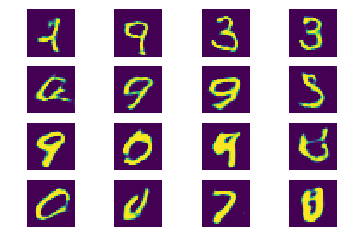

In [389]:
import matplotlib.pyplot as plt
xsim = dis.xsim.eval()
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(xsim[i][:,:,0])
    plt.axis('off')